# Movie Lens Dataset

In [38]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Resources/User_ratings_For_Movie.csv')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Resources/movies.csv')

## Data Cleaning

### Inspecting Data

In [4]:
print(ratings.head())
print(movies.head())

   userId  movieId  rating     timestamp
0       1        1     4.0  1.225735e+09
1       1      110     4.0  1.225865e+09
2       1      158     4.0  1.225734e+09
3       1      260     4.5  1.225735e+09
4       1      356     5.0  1.225735e+09
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [5]:
ratings.info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125352 entries, 0 to 125351
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Handling Missing Values

In [6]:
# Check for missing values (NaN or null values)
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    1
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


### Merge Datasets

In [7]:
df = pd.merge(ratings, movies, on='movieId')
print(df.head())

   userId  movieId  rating     timestamp             title  \
0       1        1     4.0  1.225735e+09  Toy Story (1995)   
1       2        1     5.0  8.358160e+08  Toy Story (1995)   
2       7        1     4.0  9.745180e+08  Toy Story (1995)   
3      10        1     3.0  1.430666e+09  Toy Story (1995)   
4      12        1     5.0  8.625007e+08  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125352 entries, 0 to 125351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     125352 non-null  int64  
 1   movieId    125352 non-null  int64  
 2   rating     125352 non-null  float64
 3   timestamp  125351 non-null  float64
 4   title      125352 non-null  object 
 5   genres     125352 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 6.7+ MB


### Drop Unused Columns

In [9]:
print(df['timestamp'].isnull().sum())

1


In [10]:
df = df.dropna(subset=['timestamp'])

In [11]:
# Assuming 'df' is your DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [12]:
#df.drop(['timestamp'], axis=1, inplace=True)

In [13]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## EDA

### Descriptive Statistics

In [14]:
df.describe()

,userId,movieId,rating
count,125351.000000,125351.000000,125351.000000
mean,646.079896,27844.978453,3.584323
std,372.152625,48904.887953,1.049878
min,1.000000,1.000000,0.500000
25%,318.000000,1208.000000,3.000000
50%,624.000000,3168.000000,4.000000
75%,974.000000,40815.000000,4.500000
max,1293.000000,288269.000000,5.000000


In [15]:
# It counts the occurrences of each genre in the 'genres' column using value_counts() method.
df['genres'].value_counts()

Drama                                         7958
Comedy                                        7150
Comedy|Romance                                4122
Drama|Romance                                 3534
Action|Adventure|Sci-Fi                       3498
                                              ... 
Crime|Drama|Mystery|Romance                      1
Comedy|Mystery|Romance                           1
Drama|Fantasy|War                                1
Children|Documentary                             1
Adventure|Animation|Fantasy|Musical|Sci-Fi       1
Name: genres, Length: 976, dtype: int64

In [16]:
# Understanding the data
df.describe(include='all')

<ipython-input-16-a8cd5e172dee>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,userId,movieId,rating,timestamp,title,genres
count,125351.000000,125351.000000,125351.000000,125351,125351,125351
unique,NaN,NaN,NaN,107597,11036,976
top,NaN,NaN,NaN,2017-08-30 18:51:09,"Shawshank Redemption, The (1994)",Drama
freq,NaN,NaN,NaN,160,476,7958
first,NaN,NaN,NaN,1996-02-29 16:14:11,NaN,NaN
last,NaN,NaN,NaN,2023-07-20 07:26:24,NaN,NaN
mean,646.079896,27844.978453,3.584323,NaN,NaN,NaN
std,372.152625,48904.887953,1.049878,NaN,NaN,NaN
min,1.000000,1.000000,0.500000,NaN,NaN,NaN
25%,318.000000,1208.000000,3.000000,NaN,NaN,NaN


### Visualizing the Distribution

#### Normality Check

In [17]:
# Perform Anderson-Darling test on 'rating' column
anderson_test = stats.anderson(df['rating'], dist='norm')
print(f"Anderson-Darling Test statistic: {anderson_test.statistic}, critical values: {anderson_test.critical_values}")

# Interpretation of the output
if anderson_test.statistic > max(anderson_test.critical_values):
    print("Reject null hypothesis: Data is not normally distributed.")
else:
    print("Fail to reject null hypothesis: Data might be normal.")


Anderson-Darling Test statistic: 2731.1566854082484, critical values: [0.576 0.656 0.787 0.918 1.092]
Reject null hypothesis: Data is not normally distributed.


#### Histogram

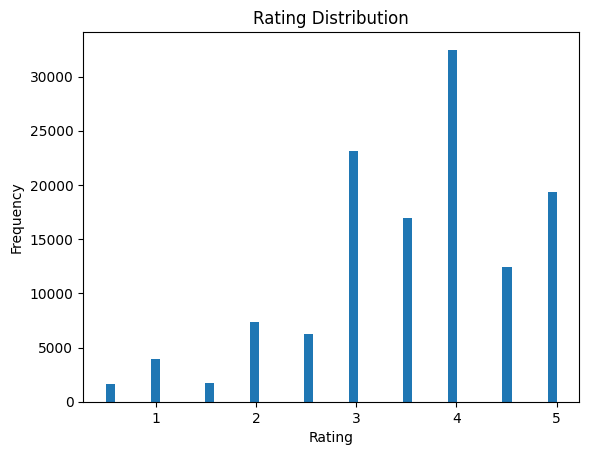

In [18]:
plt.hist(df['rating'], bins=50)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Boxplot

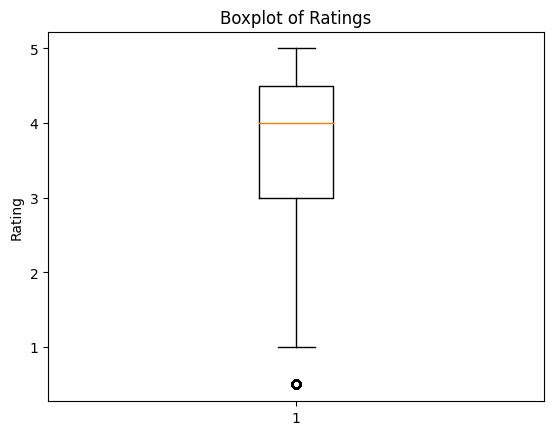

In [19]:
plt.boxplot(df['rating'])
plt.title('Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()

The ratings go from 1 to 5. The box in the center of the plot contains the middle 50% of the ratings. The line in the middle of the box represents the median rating, which is 3. The whiskers extend out from the top and bottom of the box. They show the range of the rest of the data, excluding outliers. In this case, the whiskers extend to 1 at the bottom and 4 at the top. This means that there are some ratings that are lower than 1 or higher than 4, but not many. These are considered outliers and are plotted as individual points beyond the whiskers.

- The ratings mostly range from around
- The median rating appears to be around  indicating that half of the ratings are above  and half are below.
- There are a few outliers on the lower side, indicating that there are a few unusually low ratings compared to the rest of the data.
- There are no outliers on the higher side, so the highest ratings don't differ as much from the general dataset as the lowest ones do.

#### Correlation Matrix

<ipython-input-20-587d81ac2f94>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


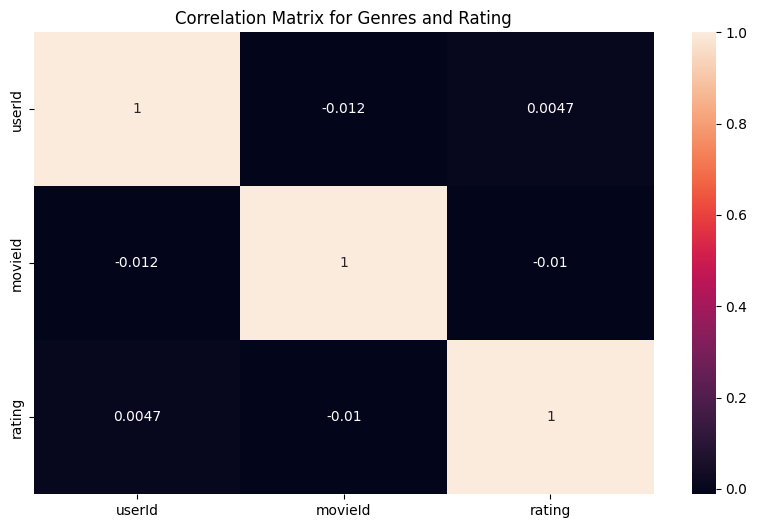

In [20]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix for Genres and Rating')
plt.show()

#### Data Distribution

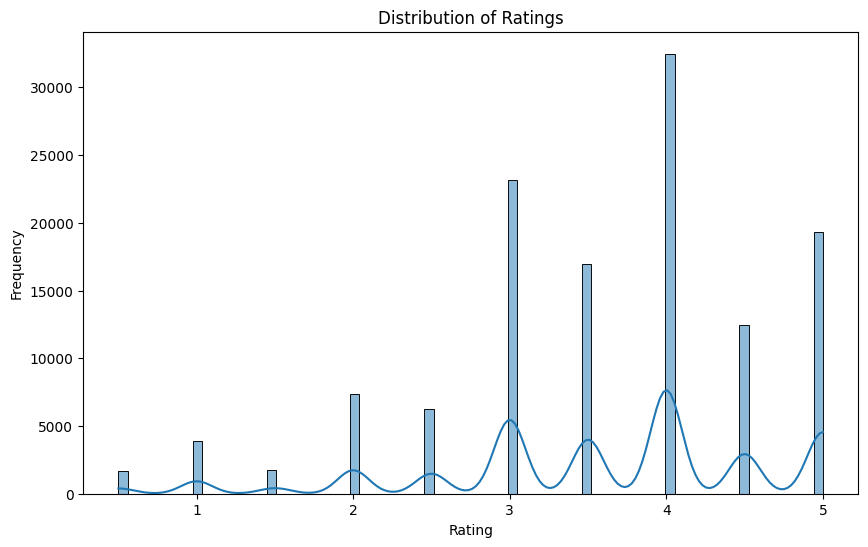

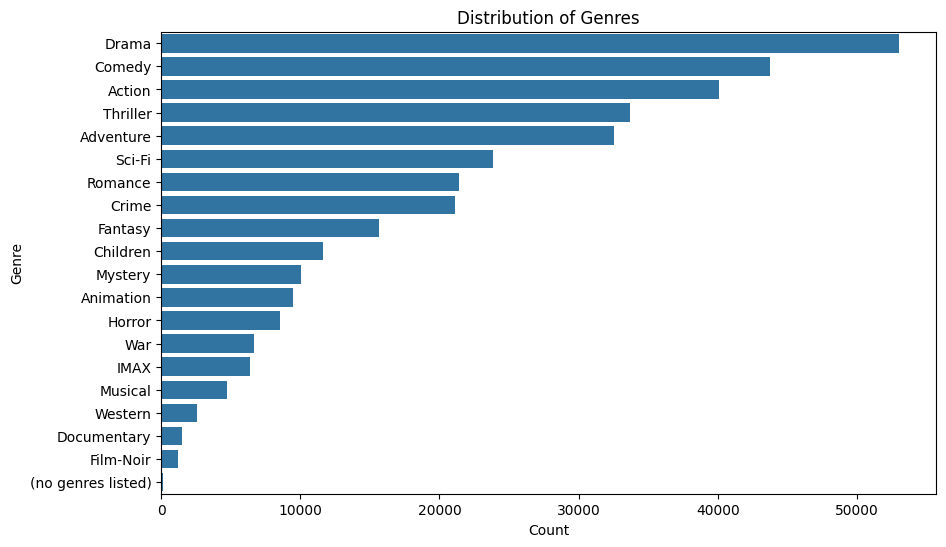

In [21]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Genres distribution
plt.figure(figsize=(10, 6))
genres = df['genres'].str.split('|').explode()
sns.countplot(y=genres, order=genres.value_counts().index)
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

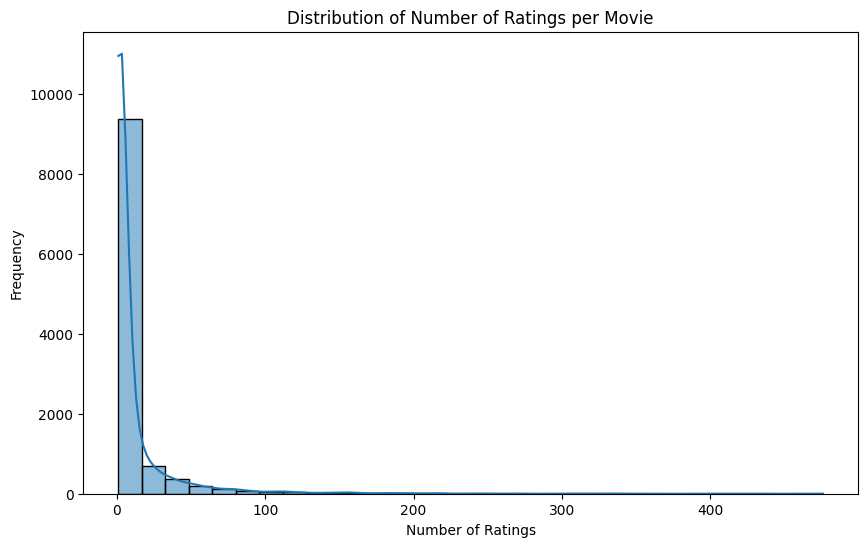

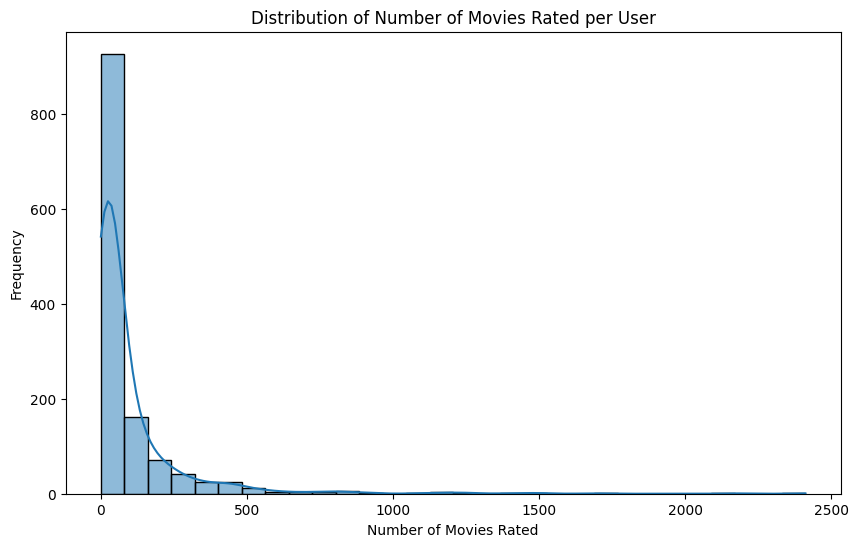

In [22]:
# Distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('movieId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

# Distribution of the number of movies rated per user
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby('userId')['rating'].count(), kde=True, bins=30)
plt.title('Distribution of Number of Movies Rated per User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Frequency')
plt.show()


### Detecting and Handling Outliers

In [23]:
# Detecting outliers in 'rating' using IQR
def count_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature]
    return outliers.count()

Q1 = df['rating'].quantile(0.25)
Q3 = df['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


# Outliers for the 'rating' column
print("Number of outliers in 'rating':", count_outliers(df, 'rating'))


Number of outliers in 'rating': 1660


In [24]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Encoding Categorical Variables

In [25]:
df_genres = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, df_genres], axis=1)

In [26]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,5.0,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.0,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,10,1,3.0,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,12,1,5.0,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Feature Scaling

In [27]:
scaler = StandardScaler()
df[['rating']] = scaler.fit_transform(df[['rating']])

### Creating New Features

In [28]:
# Extracting the number of genres per movie as a new feature
df['num_genres'] = df['genres'].apply(lambda x: len(x.split('|')))

In [29]:
df.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,num_genres
0,1,1,0.395930,2008-11-03 17:52:19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
1,2,1,1.348426,1996-06-26 19:06:11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
2,7,1,0.395930,2000-11-18 03:27:04,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
3,10,1,-0.556565,2015-05-03 15:19:54,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
4,12,1,1.348426,1997-05-01 15:32:18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5


In [30]:
# Correlation between 'rating' and 'num_genres'
spearman_corr, spearman_p_value = spearmanr(df['rating'], df['num_genres'])
print(f"Spearman's Correlation Coefficient: {spearman_corr}, P-value: {spearman_p_value}")

# Interpretation of Spearman's correlation
if spearman_p_value < 0.05:
    if spearman_corr > 0:
        print("There is a statistically significant positive correlation between 'rating' and 'num_genres'.")
    elif spearman_corr < 0:
        print("There is a statistically significant negative correlation between 'rating' and 'num_genres'.")
    else:
        print("There is a statistically significant but no linear correlation between 'rating' and 'num_genres'.")
else:
    print("There is no statistically significant correlation between 'rating' and 'num_genres'.")


Spearman's Correlation Coefficient: 0.0031106949888586475, P-value: 0.27075241756247964
There is no statistically significant correlation between 'rating' and 'num_genres'.


## Model Implementation

### 1. Create Train/Validation/Test Datasets

In [31]:
# splitting the data into three parts: training, validation, and testing datasets.

train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

### 2. Preprocessing Data

In [32]:
def create_user_item_matrix(df):    #This line creates a user-item matrix using pivot_table and fills missing values with 0.
    """
    Transforms the DataFrame into a user-item matrix
    """
    pivot_table = df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    return pivot_table

train_matrix_df = create_user_item_matrix(train_data)
validation_matrix_df = create_user_item_matrix(validation_data)
test_matrix_df = create_user_item_matrix(test_data)


# Convert the DataFrame to a sparse matrix
train_matrix = csr_matrix(train_matrix_df.values)
validation_matrix = csr_matrix(validation_matrix_df.values)
test_matrix = csr_matrix(test_matrix_df.values)

### 3. Applying SVD on Training Data

In [33]:
# Perform SVD on the CSR matrix
U, sigma, Vt = svds(train_matrix, k=50)  # k is the number of singular values and vectors
sigma_diag_matrix = np.diag(sigma)

# Convert the matrices back to DataFrames for easier interpretation and processing
user_factors_df = pd.DataFrame(U, index=train_matrix_df.index)
movie_factors_df = pd.DataFrame(Vt.T, index=train_matrix_df.columns)  # Transpose Vt to align with movie IDs

### 4. Making Prediction

In [34]:
# Reconstructing the original matrix
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)

# Convert the reconstructed matrix back to a DataFrame for easier interpretation
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=train_matrix_df.columns, index=train_matrix_df.index)

In [35]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    """
    Function to create a DataFrame with recommended movies for a user
    """
    # Get and sort the user's predictions
    user_row_number = userID - 1  # Adjust the index to match Python's 0-based indexing
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False).reset_index()
    sorted_user_predictions.columns = ['movieId', 'Predictions']

    # Get the user's data and merge in the movie information
    user_data = original_ratings_df[original_ratings_df.userId == userID]
    user_full = (user_data.merge(movies_df, on='movieId').sort_values(['rating'], ascending=False))

    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending the highest {num_recommendations} predicted ratings movies not already rated.')

    # Recommend the highest predicted rating movies that the user hasn't seen yet
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
                       merge(sorted_user_predictions, on='movieId').
                       sort_values('Predictions', ascending=False).
                       iloc[:num_recommendations])

    return user_full, recommendations


In [36]:
# For a given user, recommend movies
user_id = 1  # Example user ID
already_rated, recommendations = recommend_movies(preds_df, user_id, movies, df, 5)

print("\nRecommended movies:")
print(recommendations)

User 1 has already rated 62 movies.
Recommending the highest 5 predicted ratings movies not already rated.

Recommended movies:
      movieId                                              title  \
2148     3147                             Green Mile, The (1999)   
832      1198  Raiders of the Lost Ark (Indiana Jones and the...   
248       318                   Shawshank Redemption, The (1994)   
614       858                              Godfather, The (1972)   
6910   109487                                Interstellar (2014)   

                genres  Predictions  
2148       Crime|Drama     0.187695  
832   Action|Adventure     0.186970  
248        Crime|Drama     0.178569  
614        Crime|Drama     0.176237  
6910       Sci-Fi|IMAX     0.173286  


### 5. Evaluating the Model

RMSE and MAE Calculation: For a recommender system, both RMSE and MAE offer insights into the average error in predictions. While RMSE gives more weight to larger errors, MAE treats all errors equally.

In [37]:
def evaluate_accuracy(predictions, ground_truth):
    mse = mean_squared_error(ground_truth, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(ground_truth, predictions)
    return rmse, mae

# Assuming you have a function to get the actual ratings from the validation set
actual_ratings = validation_matrix_df.values.flatten()
predicted_ratings = preds_df.values.flatten()

# Filtering out zero values which represent missing ratings
non_zero_indices = actual_ratings.nonzero()

actual_ratings_filtered = actual_ratings[non_zero_indices]
predicted_ratings_filtered = predicted_ratings[non_zero_indices]

rmse, mae = evaluate_accuracy(predicted_ratings_filtered, actual_ratings_filtered)
print(f"RMSE: {rmse}, MAE: {mae}")


RMSE: 1.000755250856914, MAE: 0.7955134267070815
